In [1]:
# import necessary packages 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
from matplotlib.dates import drange
import seaborn as sns 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.api import VAR
from statsmodels.tools.eval_measures import rmse
import scipy as sp
import warnings
warnings.filterwarnings("ignore")
sns.set
%matplotlib inline
plt.style.use('seaborn')

In [5]:
# import Gold, Equity(Vxus) and BTC data
#the entire year 2020
gld = pd.read_csv("C:/Users\BENEL ENERGY\PP\Quant Submissions\project 2\GLD (1).csv", index_col = 'Date', parse_dates = True)[['Adj Close']]
vxus = pd.read_csv("C:/Users\BENEL ENERGY\PP\Quant Submissions\project 2\VXUS (1).csv", index_col = 'Date', parse_dates = True)[['Adj Close']]
btc = pd.read_csv('C:/Users\BENEL ENERGY\PP\Quant Submissions\project 2\BTC-USD.csv', index_col = 'Date', parse_dates = True)[['Adj Close']]

#removing missing values
btc = btc.dropna()
vxus = vxus.dropna()
gld = gld.dropna()


In [6]:
#concatinating them together
df = pd.DataFrame(index = btc.index)
df['btc'] = btc['Adj Close']
start_date = '2020-01-01'
end_date = '2020-12-31'
df['gold'] = gld['Adj Close']
df['vxus'] = vxus['Adj Close']
df = df.dropna()


In [7]:
# first divide the assets by quarters

# Start of Q2 2020
Q2_Start = '2020-04-01'

# End of Q2 2020
Q2_End = '2020-06-30'

# Start of Q3 2020
Q3_Start = '2020-07-01'

# End of Q3 2020
Q3_End = '2020-09-30'

# Start of Q4 2020
Q4_Start = '2020-10-01'

# End of Q4 2020
Q4_End = '2020-12-31'

#data in quaters
df_Q2 = df[Q2_Start:Q2_End]
df_Q3 = df[Q3_Start:Q3_End]
df_Q4 = df[Q4_Start:Q4_End]

In [8]:
#first check for stationarity
def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Result: Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Result: Data has a unit root and is non-stationary")

In [9]:
# we are going to be using gold and equity 

In [10]:
#For Q2 in Gold
adf_test(df_Q2.gold, title = 'Gold')

Augmented Dickey-Fuller Test: Gold
ADF test statistic      -3.439888
p-value                  0.009672
# lags used              0.000000
# observations          61.000000
critical value (1%)     -3.542413
critical value (5%)     -2.910236
critical value (10%)    -2.592745
Strong evidence against the null hypothesis
Reject the null hypothesis
Result: Data has no unit root and is stationary


In [11]:
#For Q3 in Gold
adf_test(df_Q3.gold, title = 'Gold')

Augmented Dickey-Fuller Test: Gold
ADF test statistic      -2.200680
p-value                  0.205999
# lags used              6.000000
# observations          57.000000
critical value (1%)     -3.550670
critical value (5%)     -2.913766
critical value (10%)    -2.594624
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Result: Data has a unit root and is non-stationary


In [12]:
#For Q2 in Vxus
adf_test(df_Q2.vxus, title = 'equity')

Augmented Dickey-Fuller Test: equity
ADF test statistic      -1.788990
p-value                  0.385941
# lags used              0.000000
# observations          61.000000
critical value (1%)     -3.542413
critical value (5%)     -2.910236
critical value (10%)    -2.592745
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Result: Data has a unit root and is non-stationary


In [13]:
#For Q3 in Vxus 
adf_test(df_Q3.vxus, title = 'equity')

Augmented Dickey-Fuller Test: equity
ADF test statistic      -3.181259
p-value                  0.021095
# lags used              0.000000
# observations          63.000000
critical value (1%)     -3.538695
critical value (5%)     -2.908645
critical value (10%)    -2.591897
Strong evidence against the null hypothesis
Reject the null hypothesis
Result: Data has no unit root and is stationary


In [14]:
#For Q2 in btc
adf_test(df_Q2.btc, title = 'BTC')

Augmented Dickey-Fuller Test: BTC
ADF test statistic      -1.999821
p-value                  0.286652
# lags used              0.000000
# observations          61.000000
critical value (1%)     -3.542413
critical value (5%)     -2.910236
critical value (10%)    -2.592745
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Result: Data has a unit root and is non-stationary


In [15]:
#For Q3 in btc 
adf_test(df_Q3.btc, title = 'BTC')

Augmented Dickey-Fuller Test: BTC
ADF test statistic      -1.775108
p-value                  0.392888
# lags used              0.000000
# observations          63.000000
critical value (1%)     -3.538695
critical value (5%)     -2.908645
critical value (10%)    -2.591897
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Result: Data has a unit root and is non-stationary


Since for the first analysis we will be fitting Q2 and Q3 data in a VAR/VARMA model therefore there Q2 series has to be stationary 
and for the second analysis we are going to fit a VAR/VARMA model to Q3 series (here it will have to be stationary as well)

In [16]:
# Now to difference the non-stationary series

In [17]:
df_new =df[['vxus','gold','btc']]
df_new = df_new.diff()[1:]

df_Q2_s = df_new[['btc', 'vxus']][Q2_Start:Q2_End]
df_Q2_s['gold'] = df_Q2.gold 

df_Q3_s = df_new[['btc', 'gold']][Q3_Start:Q3_End]
df_Q3_s['gold'] = df_Q3.vxus


In [18]:
# to confirm that they are all stationary
#For Q2 in btc 
adf_test(df_Q2_s.btc, title = 'BTC')

Augmented Dickey-Fuller Test: BTC
ADF test statistic     -9.105983e+00
p-value                 3.501742e-15
# lags used             0.000000e+00
# observations          6.100000e+01
critical value (1%)    -3.542413e+00
critical value (5%)    -2.910236e+00
critical value (10%)   -2.592745e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Result: Data has no unit root and is stationary


In [19]:
# to confirm that they are all stationary
#For Q3 in btc 
adf_test(df_Q3_s.btc, title = 'BTC')

Augmented Dickey-Fuller Test: BTC
ADF test statistic     -9.084244e+00
p-value                 3.979794e-15
# lags used             0.000000e+00
# observations          6.300000e+01
critical value (1%)    -3.538695e+00
critical value (5%)    -2.908645e+00
critical value (10%)   -2.591897e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Result: Data has no unit root and is stationary


In [20]:
#For Q2 in Vxus
adf_test(df_Q2_s.vxus, title = 'equity')

Augmented Dickey-Fuller Test: equity
ADF test statistic     -1.027085e+01
p-value                 4.005262e-18
# lags used             0.000000e+00
# observations          6.100000e+01
critical value (1%)    -3.542413e+00
critical value (5%)    -2.910236e+00
critical value (10%)   -2.592745e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Result: Data has no unit root and is stationary


In [21]:
#For Q3 in Gold
adf_test(df_Q3_s.gold, title = 'Gold')

Augmented Dickey-Fuller Test: Gold
ADF test statistic      -3.181259
p-value                  0.021095
# lags used              0.000000
# observations          63.000000
critical value (1%)     -3.538695
critical value (5%)     -2.908645
critical value (10%)    -2.591897
Strong evidence against the null hypothesis
Reject the null hypothesis
Result: Data has no unit root and is stationary


In [22]:
### Now all the series are stationary

### VAR(Train Q2 and Test Q3)

In [23]:
# since for VAR the variables must stationary so we are going to use the differenced series
# vxus data was differenced but gold was originally stationary

train = df_new[['vxus', 'gold']][Q2_Start:Q2_End]
test = df_Q3[['vxus', 'gold']]
model = VAR (train)

for p in range(1, 8):
    
    results = model.fit(p)
    print(f'ORDER {p}')
    print(f'AIC: {results.aic}')
    print('\n')

ORDER 1
AIC: 0.44456776428107225


ORDER 2
AIC: 0.5725568346448102


ORDER 3
AIC: 0.7030878354969274


ORDER 4
AIC: 0.4489115054979784


ORDER 5
AIC: 0.575685378080759


ORDER 6
AIC: 0.6196291262520999


ORDER 7
AIC: 0.5574919745880013




In [24]:
results = model.fit(1)
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 10, Nov, 2021
Time:                     13:25:25
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   0.652195
Nobs:                     61.0000    HQIC:                  0.525939
Log likelihood:          -180.670    FPE:                    1.56006
AIC:                     0.444568    Det(Omega_mle):         1.41724
--------------------------------------------------------------------
Results for equation vxus
             coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------
const           0.174294         0.096919            1.798           0.072
L1.vxus        -0.242442         0.122522           -1.979           0.048
L1.gold        -0.007316         0.058490           -0.125           0.900

Results f

In [25]:
lagged_values = train.values[-1:]
lagged_values

array([[-0.087162,  0.73999 ]])

In [26]:
z =results.forecast(y=lagged_values, steps =66)
idx = pd.date_range(Q3_Start, periods = 66, freq='B')
#idx

In [27]:
df_forecast = pd.DataFrame(data =z, index = idx, columns =['Equity_Forecast','Gold_Forecast'])
df_forecast

,Equity_Forecast,Gold_Forecast
2020-07-01,0.190012,0.353451
2020-07-02,0.125641,0.261960
2020-07-03,0.141917,0.293617
2020-07-06,0.137739,0.285123
2020-07-07,0.138814,0.287324
...,...,...
2020-09-24,0.138594,0.286873
2020-09-25,0.138594,0.286873
2020-09-28,0.138594,0.286873
2020-09-29,0.138594,0.286873


In [28]:
df_forecast.index.names = ['Date']
df_forecast.columns

df_forecast = test.merge(df_forecast, on='Date')
#df_forecast

In [29]:
# undifferencing the series
df_forecast['Equity_forecast'] = df['vxus'][Q2_End]+df_forecast['Equity_Forecast'].cumsum()
df_forecast['Gold_forecast'] = df['gold'][Q2_End]+df_forecast['Gold_Forecast'].cumsum()

In [30]:
df_test=df_forecast[['Equity_forecast','Gold_forecast']]

In [31]:
test = df_test.merge(test, on='Date')
test.tail()

,Equity_forecast,Gold_forecast,vxus,gold
Date,,,,
2020-09-24,55.974116,184.622666,50.000565,175.440002
2020-09-25,56.112710,184.909539,50.185753,174.940002
2020-09-28,56.251304,185.196413,50.868019,176.699997
2020-09-29,56.389899,185.483286,50.799789,178.190002
2020-09-30,56.528493,185.770159,50.848522,177.119995


<AxesSubplot:xlabel='Date'>

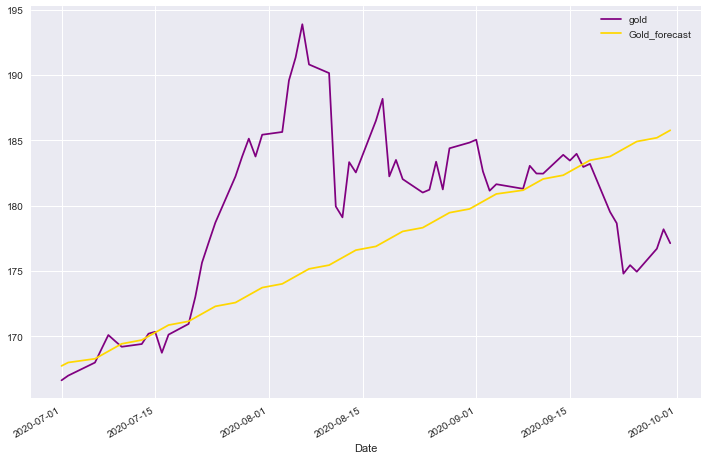

In [32]:
test.gold.plot(legend=True,figsize=(12,8), color = 'purple')
test.Gold_forecast.plot(legend = True, color ='gold')

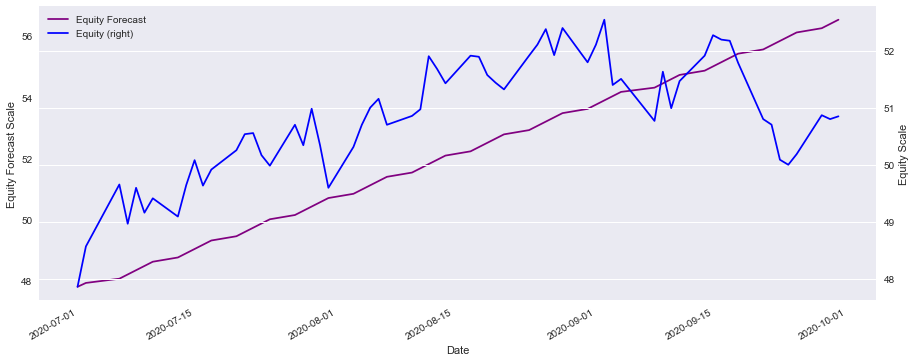

In [309]:
df_forecast.Equity_forecast.plot(figsize=(15,6), color= 'purple', legend=True, label='Equity Forecast').set_ylabel('Equity Forecast Scale')
df_forecast.vxus.plot(secondary_y = True,color = 'blue',legend = True,label ='Equity').set_ylabel('Equity Scale')
plt.show()

In [276]:
from sklearn import metrics

#GOLD
print('MAE:', metrics.mean_absolute_error(test.gold, test.Gold_forecast))
print('MSE', metrics.mean_squared_error(test.gold, test.Gold_forecast))
print('RMSE', np.sqrt(metrics.mean_squared_error(test.gold, test.Gold_forecast)))

MAE: 5.131188628955604
MSE 50.22939672985094
RMSE 7.0872700477582296


In [277]:
#EQUITY

print('MAE:', metrics.mean_absolute_error(test.vxus, test.Equity_forecast))
print('MSE', metrics.mean_squared_error(test.vxus, test.Equity_forecast))
print('RMSE', np.sqrt(metrics.mean_squared_error(test.vxus, test.Equity_forecast)))

MAE: 1.732782246432235
MSE 5.988850829255645
RMSE 2.4472128696244724


### VAR (train Q3 and test Q4)

In [278]:
# since for VAR the variables must stationary so we are going to use the differenced series
# vxus data was differenced but gold was originally stationary

train = df_new[['vxus','gold']][Q3_Start:Q3_End]
test = df_Q4[['vxus','gold']]
model = VAR (train)

for p in range(1, 8):
    
    results = model.fit(p)
    print(f'ORDER {p}')
    print(f'AIC: {results.aic}')
    print('\n')

ORDER 1
AIC: 0.2575016010943054


ORDER 2
AIC: 0.3518440829776113


ORDER 3
AIC: 0.37337263851189867


ORDER 4
AIC: 0.4085003648745221


ORDER 5
AIC: 0.519963216003074


ORDER 6
AIC: 0.4816341755699529


ORDER 7
AIC: 0.6308990979054776




In [279]:
results = model.fit(1)
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 25, Oct, 2021
Time:                     22:21:37
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   0.461610
Nobs:                     63.0000    HQIC:                  0.337778
Log likelihood:          -180.898    FPE:                    1.29388
AIC:                     0.257502    Det(Omega_mle):         1.17893
--------------------------------------------------------------------
Results for equation vxus
             coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------
const           0.061388         0.062168            0.987           0.323
L1.vxus        -0.187781         0.131148           -1.432           0.152
L1.gold        -0.026314         0.028270           -0.931           0.352

Results f

In [280]:
lagged_values = train.values[-1:]
lagged_values

array([[ 0.048733, -1.070007]])

In [281]:
z =results.forecast(y=lagged_values, steps =66)
idx = pd.date_range(Q4_Start, periods = 66, freq='B')
#idx

In [282]:
df_forecast = pd.DataFrame(data =z, index = idx, columns =['Equity_Forecast','Gold_Forecast'])
df_forecast

,Equity_Forecast,Gold_Forecast
2020-10-01,0.080393,0.128616
2020-10-02,0.042907,0.171332
2020-10-05,0.048822,0.165146
2020-10-06,0.047874,0.166139
2020-10-07,0.048026,0.165980
...,...,...
2020-12-25,0.048005,0.166002
2020-12-28,0.048005,0.166002
2020-12-29,0.048005,0.166002
2020-12-30,0.048005,0.166002


In [283]:
df_forecast.index.names = ['Date']
df_forecast.columns

df_forecast = test.merge(df_forecast, on='Date')
#df_forecast

In [284]:
# undifferencing the series
df_forecast['Equity_forecast'] = df['vxus'][Q3_End]+df_forecast['Equity_Forecast'].cumsum()
df_forecast['Gold_forecast'] = df['gold'][Q3_End]+df_forecast['Gold_Forecast'].cumsum()

In [285]:
df_test=df_forecast[['Equity_forecast','Gold_forecast']]

<AxesSubplot:ylabel='Date'>

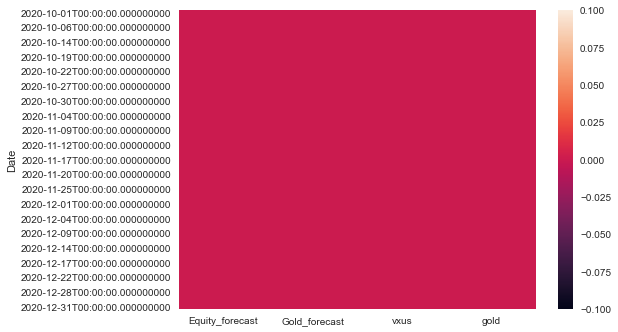

In [286]:
test = df_test.merge(test, on='Date')
sns.heatmap(test.isnull())


<AxesSubplot:xlabel='Date'>

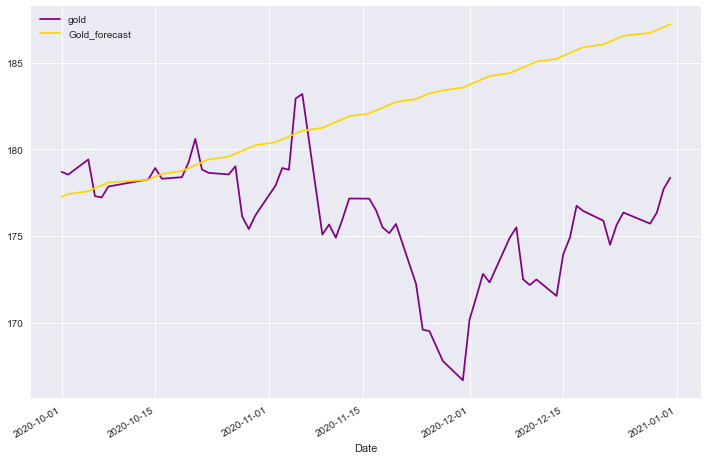

In [287]:
test.gold.plot(legend=True,figsize=(12,8), color = 'purple')
test.Gold_forecast.plot(legend = True, color ='gold')

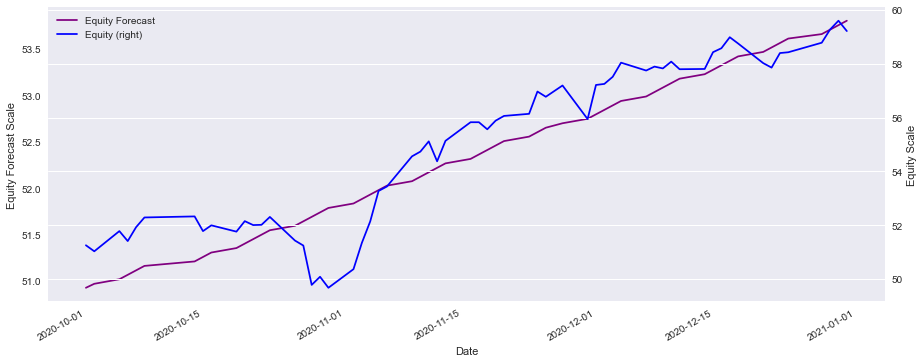

In [251]:
df_forecast.Equity_forecast.plot(figsize=(15,6), color= 'purple', legend=True, label='Equity Forecast').set_ylabel('Equity Forecast Scale')
df_forecast.vxus.plot(secondary_y = True,color = 'blue',legend = True,label ='Equity').set_ylabel('Equity Scale')
plt.show()

In [252]:
from sklearn import metrics

#GOLD
print('MAE:', metrics.mean_absolute_error(test.gold, test.Gold_forecast))
print('MSE', metrics.mean_squared_error(test.gold, test.Gold_forecast))
print('RMSE', np.sqrt(metrics.mean_squared_error(test.gold, test.Gold_forecast)))

MAE: 6.686402909951086
MSE 68.63109979204322
RMSE 8.28438892085851


In [253]:
#EQUITY

print('MAE:', metrics.mean_absolute_error(test.vxus, test.Equity_forecast))
print('MSE', metrics.mean_squared_error(test.vxus, test.Equity_forecast))
print('RMSE', np.sqrt(metrics.mean_squared_error(test.vxus, test.Equity_forecast)))

MAE: 2.9303493979129165
MSE 12.11531228139257
RMSE 3.4807057159996404
